## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from google.colab import files
import pickle
import os
import json
from google.colab import drive
warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
from dotenv import load_dotenv
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
project_config['STOCKS'] = project_config['STOCKS'].split()
project_config['TKL'] = project_config['STOCKS'][0]

# Load dataset file of current TKL

In [4]:
print(f"Loading dataset for {project_config['TKL']} .....\n")

DATASET = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
df_all = pd.read_csv(DATASET, index_col=False)
df_all = df_all.drop(columns=["Unnamed: 0"])

cols_orig = [col for col in df_all.columns if col.endswith('_orig')]
cols_normalized = [col for col in df_all.columns if not col.endswith('_orig')]

df = df_all[cols_normalized]
df_orig = df_all[['Date'] + cols_orig]

print(f"\ndf for training")
print(f"-----------------")
display(df.tail(1))

print(f"\ndf for visualization")
print(f"----------------------")
display(df_orig.tail(1))

Loading dataset for AAPL .....


df for training
-----------------


,Date,y_next,y_diff_10,NASDAQ,InflationExp,y,y_mean_22,y_mean_66,y_min_22,NASDAQ_diff_5,y_min_66,y_diff_5,y_mean_5,y_diff_22,y_min_5,Oil,y_std_5
4822,2025-12-16,0.949444,-0.040797,0.96267,0.768583,0.959203,0.964532,0.921906,0.92975,-0.020495,0.824836,-0.009054,0.966785,0.005848,0.957441,0.507872,0.007808



df for visualization
----------------------


,Date,y_diff_10_orig,NASDAQ_orig,InflationExp_orig,y_orig,y_mean_22_orig,y_mean_66_orig,y_min_22_orig,NASDAQ_diff_5_orig,y_min_66_orig,y_diff_5_orig,y_mean_5_orig,y_diff_22_orig,y_min_5_orig,Oil_orig,y_std_5_orig,y_next_orig
4822,2025-12-16,-11.580017,23111.460938,4.149,274.609985,276.122726,264.023396,266.25,-465.029297,236.470764,-2.570007,276.761993,1.659973,274.109985,55.27,2.216349,271.839996


In [5]:
from sklearn.preprocessing import MinMaxScaler

X_cols_full = [col for col in df.columns if col not in ['Date','y_next']]
X_cols_exho = [col for col in df.columns if '_' not in col and col != 'Date']
X_cols_tkl  = ['y']
y_col       = ['y_next']

y_scaler = MinMaxScaler()
y_scaler.fit(df_orig[['y_next_orig']])

MinMaxScaler()

In [6]:
def make_datasets(df, X_cols, y_col):

    LOOK_BACK_DAYS = int(project_config['LOOK_BACK_DAYS'])

    X, y = [], []

    for i in range(LOOK_BACK_DAYS, len(df)):
        X.append(df.loc[i-LOOK_BACK_DAYS:i-1, X_cols].values)
        y.append(df.loc[i, y_col].values[0])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    dates = pd.to_datetime(df['Date'])
    dates_test = dates[-len(y_test):].values

    return X_train, X_test, y_train, y_test, dates_test

In [7]:
def train_predict(X_train, X_test, y_train, y_test, features, model_name, epochs=0, batch_size=0):

  from tensorflow.keras.models import Sequential, Model
  from tensorflow.keras.layers import LSTM, Dense, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Concatenate

  epochs = int(project_config['TRAIN_EPOCS']) if epochs == 0 else epochs
  batch_size = int(project_config['TRAIN_BATCH_SIZE']) if batch_size == 0 else batch_size

  if model_name == 'Parallel.LSTM.GRU':
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))
    lstm_branch = LSTM(units=50, return_sequences=False)(input_layer)
    gru_branch = GRU(units=50, return_sequences=False)(input_layer)
    merged = Concatenate()([lstm_branch, gru_branch])
    dropout = Dropout(0.1, name='dropout_layer')(merged)
    output_layer = Dense(1, activation='sigmoid')(dropout)
    model = Model(inputs=input_layer, outputs=output_layer)

  if model_name == 'Cascase.CNN.GRU':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        GRU(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
  ])

  if model_name == 'Cascase.CNN.LSTM':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
  ])

  if model_name == 'CNN':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(1)
  ])

  if model_name == 'LSTM':
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
        LSTM(10),
        Dense(1)
  ])

  if model_name == 'GRU':
    model = Sequential([
      GRU(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
      GRU(10),
      Dense(1)
  ])

  model.compile(optimizer='adam', loss='mse')

  print("\n=====================================================================\n")
  print(f"TKL: {project_config['TKL']}")
  print(f"Model: {model_name}")
  print(f"Features: {features}")
  model.summary()

  history = model.fit(X_train, y_train,
                      epochs=int(project_config['TRAIN_EPOCS']),
                      batch_size=int(project_config['TRAIN_BATCH_SIZE']),
                      validation_data=(X_test, y_test),
                      verbose=1)

  pred = model.predict(X_test)
  unscaled_prediction = y_scaler.inverse_transform(pred.reshape(-1, 1))
  unscaled_y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))

  from sklearn.metrics import mean_absolute_error
  mae = mean_absolute_error(unscaled_y_test, unscaled_prediction)

  from sklearn.metrics import r2_score
  r2 = r2_score(unscaled_y_test, unscaled_prediction)

  print(f"TKL: {project_config['TKL']}")
  print(f"Model: {model_name}")
  print(f"Features: {features}")
  print(f"MAE: {mae:.4f}")
  print(f"R²: {r2:.4f}")

  return unscaled_prediction, unscaled_y_test, model

In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def race_models(tkl, models_to_try):

  results_df = pd.DataFrame(columns=[ "model_name", "X_cols",  "prediction", "mae", "r2", "model" ])

  for X_cols in [X_cols_full, X_cols_exho, X_cols_tkl]:

    X_train, X_test, y_train, y_test, dates_test = make_datasets(df, X_cols, y_col)

    if 'Parallel.LSTM.GRU' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Parallel.LSTM.GRU")
      results_df.loc[len(results_df)] = {
        "model_name": "Parallel.LSTM.GRU",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'Cascase.CNN.GRU' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Cascase.CNN.GRU")
      results_df.loc[len(results_df)] = {
        "model_name": "Cascase.CNN.GRU",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'Cascase.CNN.LSTM' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Cascase.CNN.LSTM")
      results_df.loc[len(results_df)] = {
        "model_name": "Cascase.CNN.LSTM",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'CNN' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="CNN")
      results_df.loc[len(results_df)] = {
        "model_name": "CNN",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'GRU' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="GRU")
      results_df.loc[len(results_df)] = {
        "model_name": "GRU",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
      }

    if 'LSTM' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="LSTM")
      results_df.loc[len(results_df)] = {
        "model_name": "LSTM",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
      }

  return results_df, dates_test, unscaled_y_test

In [9]:
def plot_results(results_df, dates_test, unscaled_y_test):

  import matplotlib.dates as mdates # Added import

  for model_name in results_df.model_name.unique():
    plt.figure(figsize=(10,6))
    plt.title(f"{project_config['TKL']} {model_name}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual", linewidth=2, color='black')

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.model_name == model_name].iterrows():
      plt.plot(dates_test, entry.prediction, label=f"features: {entry.X_cols}", linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    image_name = f"{os.getenv('PROJECT_PATH')}{project_config['images_directory']}{project_config['TKL']}.{model_name}.png"
    plt.savefig(image_name, dpi=300, bbox_inches="tight")
    plt.show()

  # Convert lists in 'X_cols' to tuples for unique identification
  # This is necessary because lists are unhashable, causing TypeError with .unique()
  results_df['X_cols_tuple'] = results_df['X_cols'].apply(tuple)

  for features_tuple in results_df.X_cols_tuple.unique():
    plt.figure(figsize=(10,6))
    # Convert tuple back to list for display purposes in the title
    features = list(features_tuple)
    plt.title(f"{project_config['TKL']} {features}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual", linewidth=2, color='black')

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.X_cols_tuple == features_tuple].iterrows():
      plt.plot(dates_test, entry.prediction, label=f":{entry.model_name}", linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    image_name = f"{os.getenv('PROJECT_PATH')}{project_config['images_directory']}{project_config['TKL']}.{features}.png"
    plt.savefig(image_name, dpi=300, bbox_inches="tight")
    plt.show()



TKL: AAPL
Model: Parallel.LSTM.GRU
Features: ['y_diff_10', 'NASDAQ', 'InflationExp', 'y', 'y_mean_22', 'y_mean_66', 'y_min_22', 'NASDAQ_diff_5', 'y_min_66', 'y_diff_5', 'y_mean_5', 'y_diff_22', 'y_min_5', 'Oil', 'y_std_5']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 66, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50)        │     13,200 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 50)        │     10,050 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 100)       │          0 │ concatenate[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        101 │ dropout_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,351 (91.21 KB)

 Trainable params: 23,351 (91.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0493 - val_loss: 0.0131
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 6.9499e-04 - val_loss: 0.0080
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 4.1466e-04 - val_loss: 0.0102
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 3.2860e-04 - val_loss: 0.0086
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 2.5459e-04 - val_loss: 0.0074
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 2.0036e-04 - val_loss: 0.0084
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.9648e-04 - val_loss: 0.0062
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 1.8617e-04 - val_loss: 0.0073
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 1.5437e-04 - val_loss: 0.0065
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.3374e-04 - val_loss: 0.0071
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - loss: 1.3993e-04 - val_loss: 0.00

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 64)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,645 (84.55 KB)

 Trainable params: 21,645 (84.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5.3782e-05 - val_loss: 0.0040
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 5.7441e-05 - val_loss: 0.0042
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 4.8742e-05 - val_loss: 0.0031
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 6.1222e-05 - val_loss: 0.0039
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.1724e-05 - val_loss: 0.0025
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.0339e-05 - val_loss: 0.0021
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 4.3889e-05 - val_loss: 0.0016
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 4.2872e-05 - val_loss: 0.0016
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 4.9977e-05 - val_loss: 0.0017
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 4.2468e-05 - val_loss: 0.0021
E

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 66, 50)         │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,921 (46.57 KB)

 Trainable params: 11,921 (46.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 1.0018e-04 - val_loss: 0.0015
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 5.6297e-05 - val_loss: 8.4190e-04
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - loss: 3.7835e-05 - val_loss: 7.9921e-04
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 4.4600e-05 - val_loss: 8.6188e-04
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 3.2094e-05 - val_loss: 0.0011
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 4.3925e-05 - val_loss: 6.0045e-04
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 3.2968e-05 - val_loss: 0.0012
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - loss: 3.2511e-05 - val_loss: 8.4446e-04
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - loss: 3.7117e-05 - val_loss: 6.3655e-04
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 66, 50)         │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,651 (61.14 KB)

 Trainable params: 15,651 (61.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0029 - val_loss: 0.0086
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 6.7238e-05 - val_loss: 0.0067
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 4.9362e-05 - val_loss: 0.0028
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 5.5180e-05 - val_loss: 0.0033
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 4.5695e-05 - val_loss: 0.0037
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 4.5017e-05 - val_loss: 0.0021
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 4.6273e-05 - val_loss: 0.0035
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 3.7906e-05 - val_loss: 0.0024
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 3.8135e-05 - val_loss: 0.0046
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 4.8230e-05 - val_loss: 0.0031
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 3.8066e-05 - val_loss: 0.002

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 66, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 50)        │     11,000 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 50)        │      8,400 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ gru_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 100)       │          0 │ concatenate_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        101 │ dropout_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,501 (76.18 KB)

 Trainable params: 19,501 (76.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0554 - val_loss: 0.1768
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0017 - val_loss: 0.0533
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 4.8699e-04 - val_loss: 0.0219
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 2.8941e-04 - val_loss: 0.0221
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 2.5515e-04 - val_loss: 0.0129
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 2.5661e-04 - val_loss: 0.0113
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.9707e-04 - val_loss: 0.0106
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 1.8021e-04 - val_loss: 0.0087
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 2.4491e-04 - val_loss: 0.0076
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 1.6921e-04 - val_loss: 0.0047
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.5956e-04 - val_loss: 0.0065
Ep

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 50)             │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,533 (76.30 KB)

 Trainable params: 19,533 (76.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0049 - val_loss: 0.0188
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 1.0298e-04 - val_loss: 0.0097
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.8599e-05 - val_loss: 0.0103
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 7.6237e-05 - val_loss: 0.0057
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 7.1726e-05 - val_loss: 0.0037
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 6.7205e-05 - val_loss: 0.0038
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.6173e-05 - val_loss: 0.0040
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6.3077e-05 - val_loss: 0.0039
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5.1732e-05 - val_loss: 0.0063
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 7.3448e-05 - val_loss: 0.0083
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5.3228e-05 - val_loss: 0.0061
E

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 66, 50)         │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,271 (40.12 KB)

 Trainable params: 10,271 (40.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 0.0166 - val_loss: 0.0213
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 3.3738e-04 - val_loss: 0.0066
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 1.0216e-04 - val_loss: 0.0032
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 6.8449e-05 - val_loss: 0.0037
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 5.8677e-05 - val_loss: 0.0029
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 5.1599e-05 - val_loss: 0.0031
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 4.5111e-05 - val_loss: 0.0020
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 4.3127e-05 - val_loss: 0.0026
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 4.4913e-05 - val_loss: 0.0014
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 4.2794e-05 - val_loss: 0.0014
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 3.8729e-05 - val_loss: 7.253

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 66, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,451 (52.54 KB)

 Trainable params: 13,451 (52.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0103 - val_loss: 0.0282
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 1.4152e-04 - val_loss: 0.0241
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 1.2294e-04 - val_loss: 0.0190
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.1286e-04 - val_loss: 0.0164
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 1.0897e-04 - val_loss: 0.0166
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.1703e-04 - val_loss: 0.0169
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 9.8336e-05 - val_loss: 0.0106
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.0346e-04 - val_loss: 0.0080
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 8.8645e-05 - val_loss: 0.0057
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 8.2001e-05 - val_loss: 0.0049
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 7.2265e-05 - val_loss: 0.003

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 66, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 50)        │     10,400 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 50)        │      7,950 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100)       │          0 │ lstm_6[0][0],     │
│ (Concatenate)       │                   │            │ gru_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 100)       │          0 │ concatenate_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │        101 │ dropout_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,451 (72.07 KB)

 Trainable params: 18,451 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0728 - val_loss: 0.0140
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 4.2836e-04 - val_loss: 0.0101
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 2.3648e-04 - val_loss: 0.0077
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 2.0865e-04 - val_loss: 0.0045
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 1.9403e-04 - val_loss: 0.0039
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.5301e-04 - val_loss: 0.0042
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.4023e-04 - val_loss: 0.0031
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 1.4241e-04 - val_loss: 0.0029
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.2601e-04 - val_loss: 0.0037
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 1.3028e-04 - val_loss: 0.0033
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 1.2599e-04 - val_loss: 0

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 50)             │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,957 (74.05 KB)

 Trainable params: 18,957 (74.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0083 - val_loss: 7.7219e-04
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.0627e-05 - val_loss: 0.0011
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.5083e-05 - val_loss: 8.6219e-04
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 4.4739e-05 - val_loss: 7.4811e-04
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4.8558e-05 - val_loss: 5.4381e-04
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 5.0465e-05 - val_loss: 7.6976e-04
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 4.0220e-05 - val_loss: 5.9938e-04
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.3694e-05 - val_loss: 0.0010
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 4.7093e-05 - val_loss: 8.2886e-04
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.5849e-05 - val_loss: 7.7820e-04
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss:

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 66, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,821 (38.36 KB)

 Trainable params: 9,821 (38.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 0.0049 - val_loss: 6.0320e-04
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 4.3158e-05 - val_loss: 5.7646e-04
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 4.1426e-05 - val_loss: 4.9989e-04
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 3.9731e-05 - val_loss: 4.8548e-04
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 4.2719e-05 - val_loss: 5.2607e-04
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 3.8937e-05 - val_loss: 4.8343e-04
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 3.9586e-05 - val_loss: 6.2176e-04
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 3.4825e-05 - val_loss: 4.3286e-04
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 4.1874e-05 - val_loss: 4.2666e-04
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 3.2671e-05 - val_loss: 4.4439e-04
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 66, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 10)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,851 (50.20 KB)

 Trainable params: 12,851 (50.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0076 - val_loss: 0.0030
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 9.8813e-05 - val_loss: 0.0032
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 8.2412e-05 - val_loss: 0.0032
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 8.8947e-05 - val_loss: 0.0025
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 9.2576e-05 - val_loss: 0.0017
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 7.6057e-05 - val_loss: 0.0024
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 8.3202e-05 - val_loss: 0.0016
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 7.3049e-05 - val_loss: 0.0016
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 7.3246e-05 - val_loss: 0.0030
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 7.4172e-05 - val_loss: 0.0013
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 7.3965e-05 - val_loss: 0.001

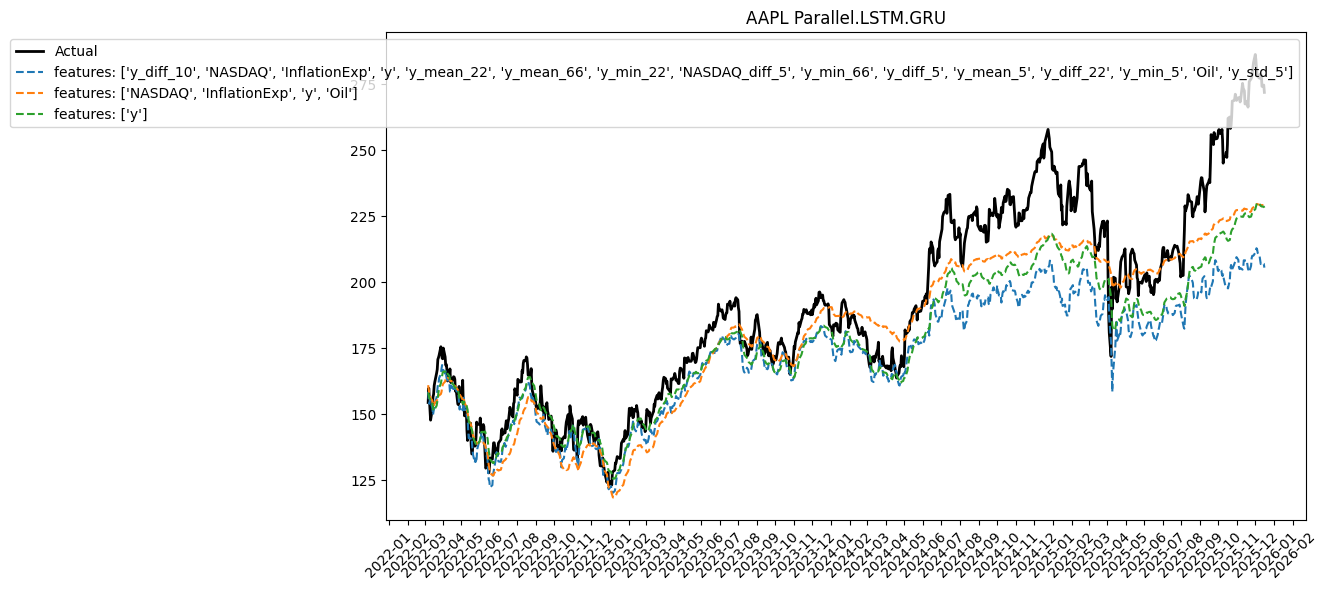

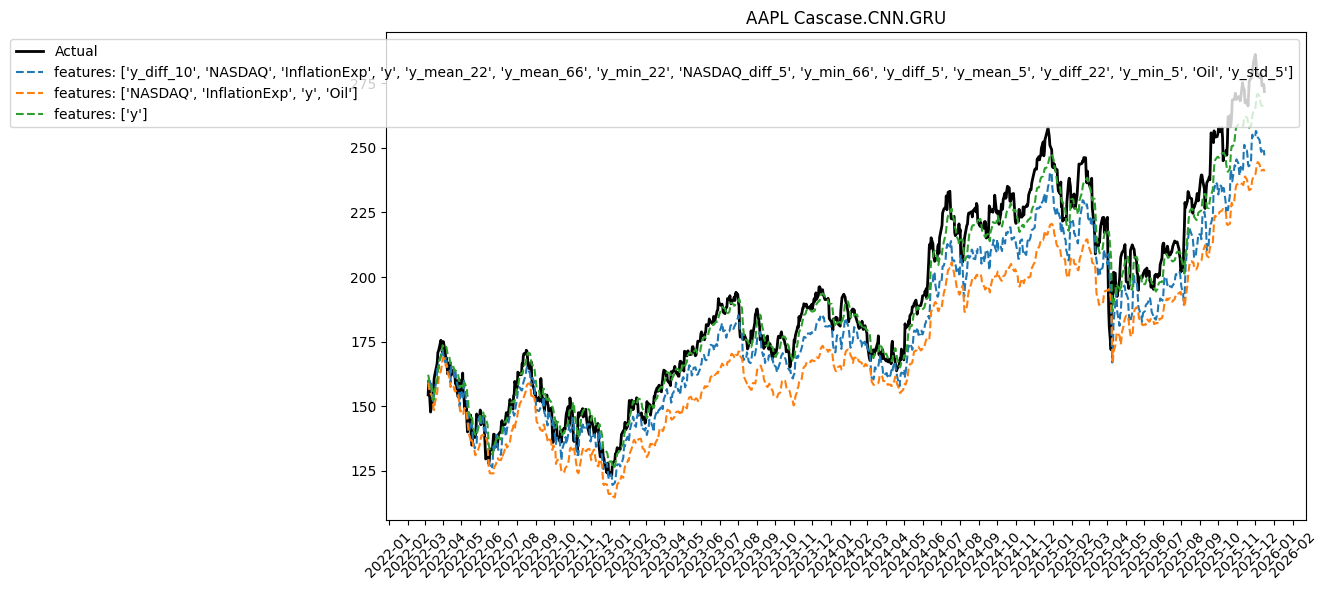

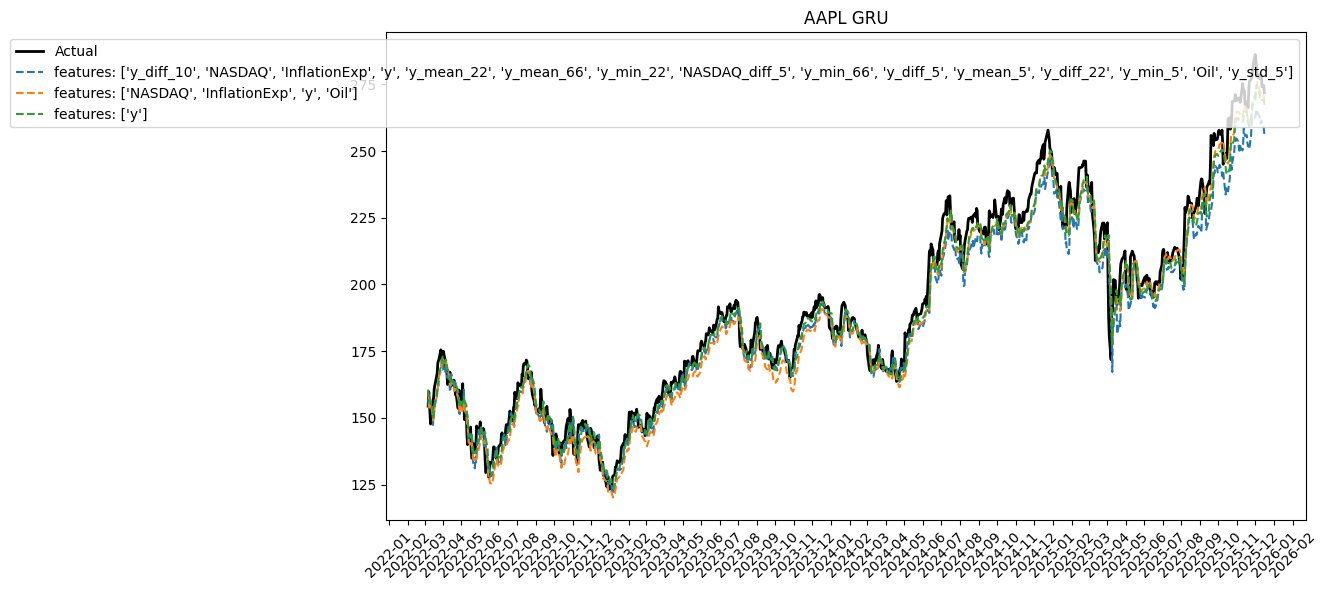

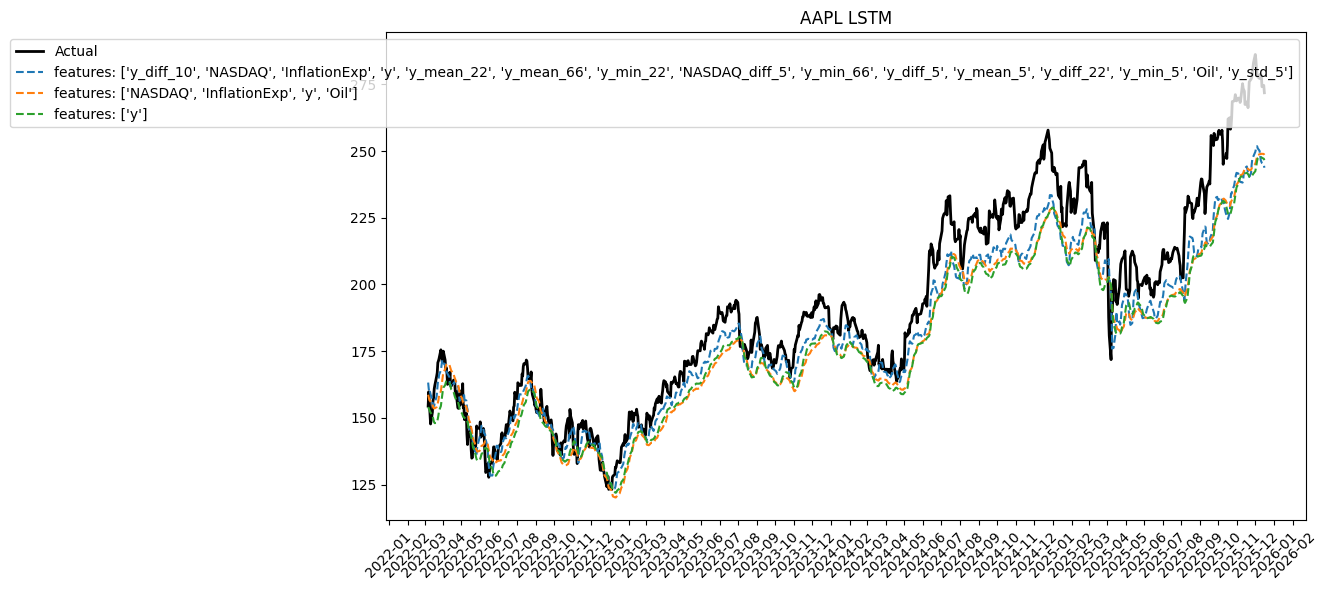

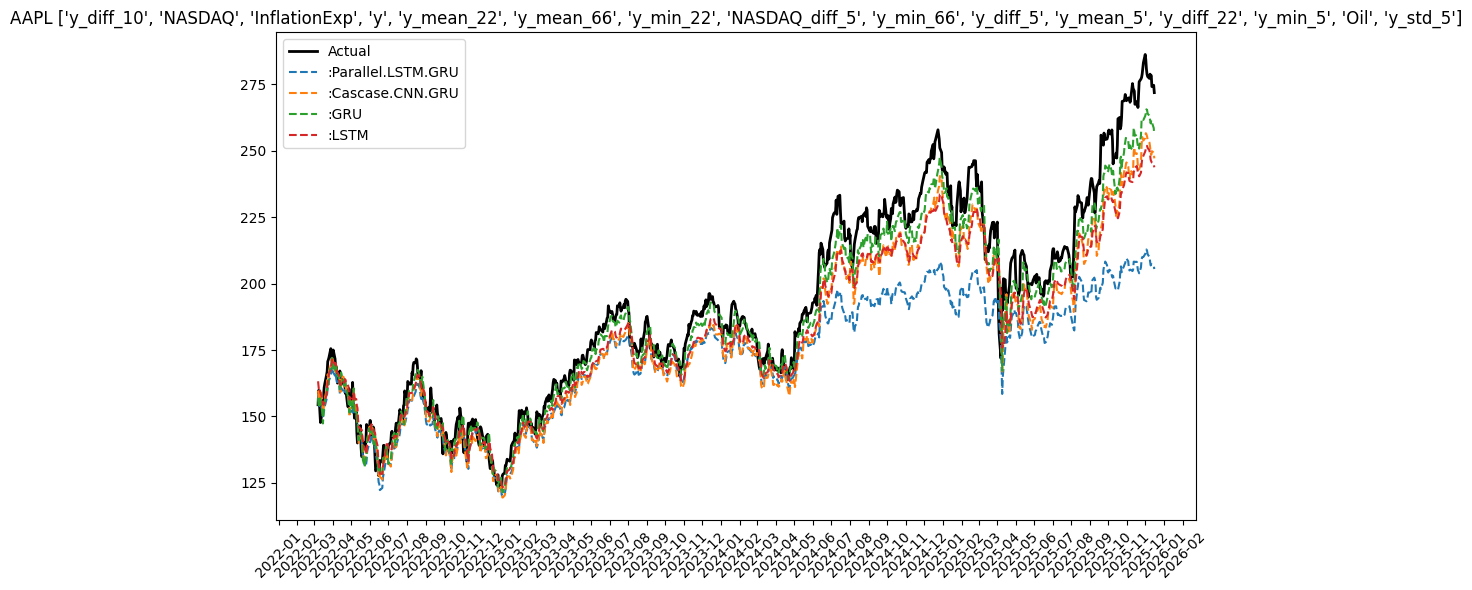

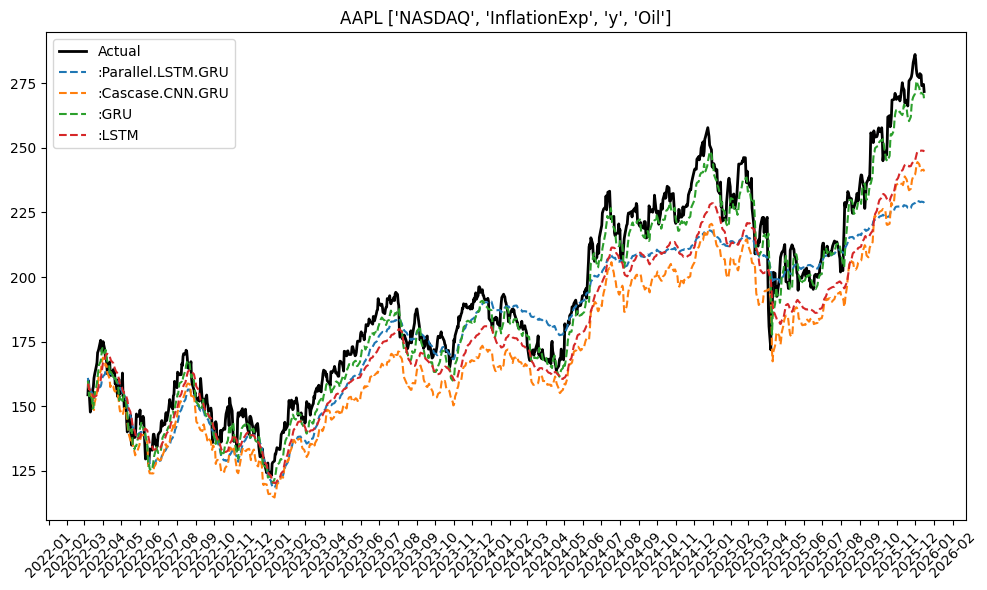

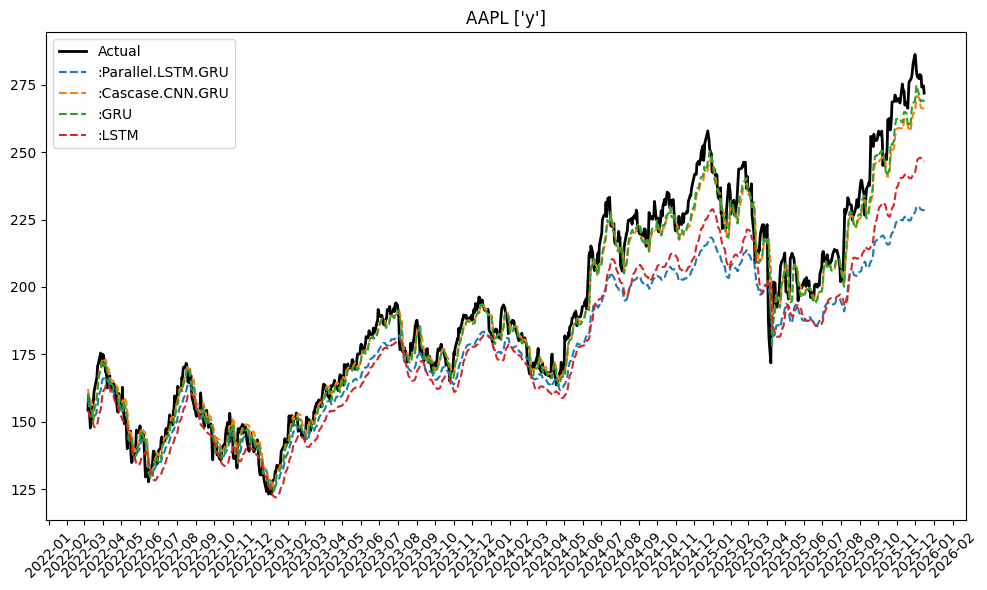

AND THE WINNER for AAPL IS ...


,model_name,X_cols,mae,r2
10,GRU,[y],4.770608,0.972478
9,Cascase.CNN.GRU,[y],5.127473,0.966666
6,GRU,"[NASDAQ, InflationExp, y, Oil]",5.677784,0.965926
2,GRU,"[y_diff_10, NASDAQ, InflationExp, y, y_mean_22...",6.113281,0.954290
3,LSTM,"[y_diff_10, NASDAQ, InflationExp, y, y_mean_22...",10.046196,0.881985
1,Cascase.CNN.GRU,"[y_diff_10, NASDAQ, InflationExp, y, y_mean_22...",10.738589,0.882070
4,Parallel.LSTM.GRU,"[NASDAQ, InflationExp, y, Oil]",12.283931,0.812518
7,LSTM,"[NASDAQ, InflationExp, y, Oil]",13.179212,0.824625
11,LSTM,[y],13.627749,0.810948
8,Parallel.LSTM.GRU,[y],14.006994,0.754353


In [10]:
results_df, dates_test, unscaled_y_test = race_models(project_config['TKL'], project_config['RACING_MODELS'].split())
plot_results(results_df, dates_test, unscaled_y_test)

print(f"AND THE WINNER for {project_config['TKL']} IS ...")
display(results_df[['model_name', 'X_cols', 'mae', 'r2']].sort_values(by='mae', ascending=True))

winning_model = results_df.sort_values(by='mae', ascending=True).iloc[0].model
winning_model_name = results_df.sort_values(by='mae', ascending=True).iloc[0].model_name
winning_model_features = results_df.sort_values(by='mae', ascending=True).iloc[0].X_cols

model_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.model.{winning_model_name}.{winning_model_features}.keras"
df_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df.pkl"
df_orig_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df_orig.pkl"

winning_model.save(model_path)
df[ ['Date','y_next']+winning_model_features ].to_pickle(df_path)
df_orig[ ['Date','y_next_orig'] + [f'{feat}_orig' for feat in winning_model_features] ].to_pickle(df_orig_path)